In [1]:
from torchvision import transforms
from PIL import Image
import torch
from torch.utils.data import Dataset
import os
import json

class MultiTaskDataset(Dataset):
    def __init__(self, label_dir, image_dir, transform=None):
        self.label_dir = label_dir
        self.image_dir = image_dir
        self.transform = transform
        self.data = []

        label_folders = sorted(os.listdir(label_dir))
        image_folders = sorted(os.listdir(image_dir))

        for label_folder, image_folder in zip(label_folders, image_folders):
            label_subdir = os.path.join(label_dir, label_folder)
            image_subdir = os.path.join(image_dir, image_folder)

            if os.path.isdir(label_subdir) and os.path.isdir(image_subdir):
                for file in os.listdir(label_subdir):
                    if file.endswith(".json"):
                        json_path = os.path.join(label_subdir, file)
                        with open(json_path, "r") as f:
                            try:
                                data = json.load(f)
                                image_filename = f"{data['filename']}.{data['format']}"
                                image_path = os.path.join(image_subdir, image_filename)

                                if os.path.exists(image_path):
                                    data["image_path"] = image_path
                                    self.data.append(data)
                                else:
                                    print(f"Image not found: {image_path}")
                            except json.JSONDecodeError as e:
                                print(f"Error loading JSON {json_path}: {e}")

        print(f"Total samples loaded: {len(self.data)}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image_path = item["image_path"]
        image = Image.open(image_path).convert("RGB")  # Load image as PIL.Image

        if self.transform:
            image = self.transform(image)  # Transform to tensor

        age = torch.tensor(item["age_past"], dtype=torch.float32)
        gender = torch.tensor(0 if item["gender"] == "male" else 1, dtype=torch.float32)

        return image, age, gender


# 데이터 전처리 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet 입력 크기와 맞추기
    transforms.ToTensor(),         # PIL 이미지를 Tensor로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet 정규화
])

image_dir = "/home/hyun/dev_ws/ROS_project/age/Training/images"
label_dir = "/home/hyun/dev_ws/ROS_project/age/Training/labels"

# 데이터셋 생성
dataset = MultiTaskDataset(label_dir, image_dir, transform=transform)

# DataLoader 생성
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# 데이터 확인
for images, ages, genders in dataloader:
    print(f"Image batch shape: {images.shape}")  # [batch_size, channels, height, width]
    print(f"Age batch: {ages}")
    print(f"Gender batch: {genders}")
    break


Image not found: /home/hyun/dev_ws/ROS_project/age/Training/images/TS_0039/0039_1988_34_00000050_D.png
Image not found: /home/hyun/dev_ws/ROS_project/age/Training/images/TS_0039/0039_1988_34_00000048_D.png
Image not found: /home/hyun/dev_ws/ROS_project/age/Training/images/TS_0039/0039_1988_34_00000049_D.png
Image not found: /home/hyun/dev_ws/ROS_project/age/Training/images/TS_0047/0047_1987_15_00000005_F.png
Image not found: /home/hyun/dev_ws/ROS_project/age/Training/images/TS_0047/0047_1987_06_00000046_F.png
Image not found: /home/hyun/dev_ws/ROS_project/age/Training/images/TS_0047/0047_1987_36_00000038_D.png
Image not found: /home/hyun/dev_ws/ROS_project/age/Training/images/TS_0047/0047_1987_25_00000019_D.png
Image not found: /home/hyun/dev_ws/ROS_project/age/Training/images/TS_0047/0047_1987_19_00000009_D.png
Image not found: /home/hyun/dev_ws/ROS_project/age/Training/images/TS_0047/0047_1987_19_00000012_F.png
Image not found: /home/hyun/dev_ws/ROS_project/age/Training/images/TS_004

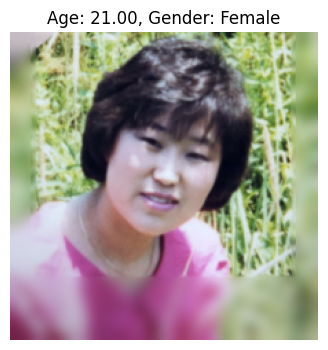

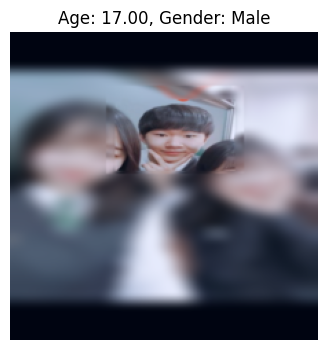

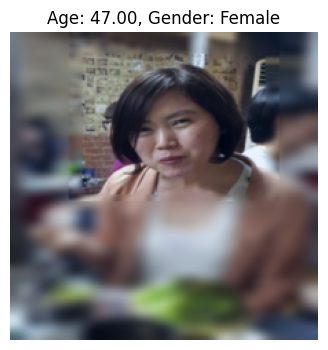

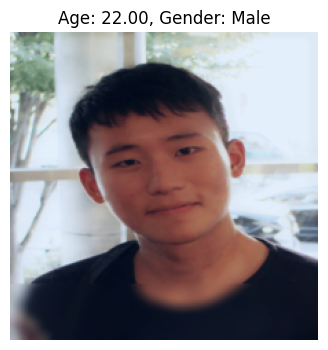

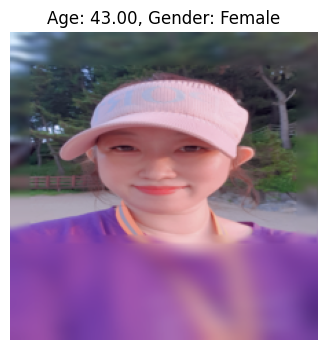

In [2]:
import random
import matplotlib.pyplot as plt

# 랜덤 샘플링 및 시각화 함수
def visualize_random_samples(dataloader, num_samples=5):
    # DataLoader에서 한 배치 가져오기
    images, ages, genders = next(iter(dataloader))

    # 랜덤으로 num_samples 개 샘플 선택
    indices = random.sample(range(len(images)), num_samples)

    for idx in indices:
        image = images[idx].permute(1, 2, 0).numpy()  # [C, H, W] -> [H, W, C]
        image = (image - image.min()) / (image.max() - image.min())  # Normalize된 데이터 조정
        age = ages[idx].item()
        gender = "Male" if genders[idx].item() == 0 else "Female"

        # 시각화
        plt.figure(figsize=(4, 4))
        plt.imshow(image)
        plt.title(f"Age: {age:.2f}, Gender: {gender}")
        plt.axis('off')
        plt.show()

# 랜덤 샘플 시각화 실행
visualize_random_samples(dataloader, num_samples=5)


In [3]:
from sklearn.model_selection import train_test_split

# 데이터셋 전체를 리스트로 저장
data_indices = list(range(len(dataset)))

# Train(80%) / Temp(20%) 나누기
train_indices, temp_indices = train_test_split(data_indices, test_size=0.2, random_state=42)

# Temp 데이터를 Validation(10%) / Test(10%)로 나누기
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42)

print(f"Train size: {len(train_indices)}, Validation size: {len(val_indices)}, Test size: {len(test_indices)}")


Train size: 32000, Validation size: 4000, Test size: 4000


In [4]:
from torch.utils.data import Subset

# Subset 생성
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [5]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import resnet18
import numpy as np
from sklearn.metrics import accuracy_score
from torchvision import transforms
import cv2
from PIL import Image
from tqdm import tqdm

class AgeNormalizer:
    def __init__(self, min_age=0, max_age=100):
        self.min_age = min_age
        self.max_age = max_age
    
    def normalize(self, age):
        return (age - self.min_age) / (self.max_age - self.min_age)
    
    def denormalize(self, normalized_age):
        return normalized_age * (self.max_age - self.min_age) + self.min_age

class AgeLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super().__init__()
        self.alpha = alpha
        self.mse = nn.MSELoss()
        
    def forward(self, pred, target):
        mse_loss = self.mse(pred, target)
        diff_loss = torch.mean(torch.abs(pred - target))
        return mse_loss + self.alpha * diff_loss

class ImprovedGenderAgeModel(nn.Module):
    def __init__(self, pretrained=True):
        super(ImprovedGenderAgeModel, self).__init__()
        self.backbone = resnet18(pretrained=pretrained)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        
        self.shared_fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm1d(512)  # Add BatchNorm for better training stability
        )
        
        self.age_head = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.BatchNorm1d(256),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()  # Normalize age output to [0,1]
        )
        
        self.gender_head = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.BatchNorm1d(256),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.shared_fc(x)
        age = self.age_head(x)
        gender = self.gender_head(x)
        return age, gender

# 향상된 데이터 증강
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Larger size for cropping
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def calculate_metrics(pred_ages, true_ages, pred_genders, true_genders):
    age_mae = np.mean(np.abs(pred_ages - true_ages))
    age_mse = np.mean((pred_ages - true_ages) ** 2)
    age_acc_5 = np.mean(np.abs(pred_ages - true_ages) <= 5)  # ±5 years accuracy
    gender_acc = accuracy_score(true_genders, pred_genders)
    
    return {
        'age_mae': age_mae,
        'age_mse': age_mse,
        'age_acc_5': age_acc_5,
        'gender_acc': gender_acc
    }

def train_epoch(model, train_loader, optimizer, device, age_normalizer, age_weight=1.0, gender_weight=1.0):
    model.train()
    total_loss = 0
    age_preds, age_trues = [], []
    gender_preds, gender_trues = [], []
    
    pbar = tqdm(train_loader, desc='Training')
    for images, ages, genders in pbar:
        images = images.to(device)
        ages = torch.tensor([age_normalizer.normalize(age) for age in ages]).float().to(device)
        genders = genders.float().to(device)

        optimizer.zero_grad()
        age_output, gender_output = model(images)
        
        age_loss = AgeLoss()(age_output.squeeze(), ages) * age_weight
        gender_loss = nn.BCEWithLogitsLoss()(gender_output.squeeze(), genders) * gender_weight
        loss = age_loss + gender_loss
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Store predictions for metrics
        age_preds.extend([age_normalizer.denormalize(age.item()) for age in age_output])
        age_trues.extend([age_normalizer.denormalize(age.item()) for age in ages])
        gender_preds.extend(torch.sigmoid(gender_output).squeeze().cpu().detach().numpy() > 0.5)
        gender_trues.extend(genders.cpu().numpy())
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    metrics = calculate_metrics(np.array(age_preds), np.array(age_trues),
                              np.array(gender_preds), np.array(gender_trues))
    
    return total_loss / len(train_loader), metrics

def validate(model, val_loader, device, age_normalizer, age_weight=1.0, gender_weight=1.0):
    model.eval()
    total_loss = 0
    age_preds, age_trues = [], []
    gender_preds, gender_trues = [], []
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc='Validation')
        for images, ages, genders in pbar:
            images = images.to(device)
            ages = torch.tensor([age_normalizer.normalize(age) for age in ages]).float().to(device)
            genders = genders.float().to(device)

            age_output, gender_output = model(images)
            
            age_loss = AgeLoss()(age_output.squeeze(), ages) * age_weight
            gender_loss = nn.BCEWithLogitsLoss()(gender_output.squeeze(), genders) * gender_weight
            loss = age_loss + gender_loss
            
            total_loss += loss.item()
            
            age_preds.extend([age_normalizer.denormalize(age.item()) for age in age_output])
            age_trues.extend([age_normalizer.denormalize(age.item()) for age in ages])
            gender_preds.extend(torch.sigmoid(gender_output).squeeze().cpu().numpy() > 0.5)
            gender_trues.extend(genders.cpu().numpy())
            
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    metrics = calculate_metrics(np.array(age_preds), np.array(age_trues),
                              np.array(gender_preds), np.array(gender_trues))
    
    return total_loss / len(val_loader), metrics

# 학습 실행 코드
def train_model(train_loader, val_loader, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    model = ImprovedGenderAgeModel().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, verbose=True)
    age_normalizer = AgeNormalizer()
    
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    
    history = {
        'train_loss': [], 'val_loss': [],
        'train_metrics': [], 'val_metrics': []
    }
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        train_loss, train_metrics = train_epoch(
            model, train_loader, optimizer, device, age_normalizer
        )
        
        val_loss, val_metrics = validate(
            model, val_loader, device, age_normalizer
        )
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_metrics'].append(train_metrics)
        history['val_metrics'].append(val_metrics)
        
        # Print metrics
        print(f"\nTrain - Loss: {train_loss:.4f}")
        print(f"Train Metrics: {train_metrics}")
        print(f"Val - Loss: {val_loss:.4f}")
        print(f"Val Metrics: {val_metrics}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_gender_age_model.pth')
            epochs_without_improvement = 0
            print("New best model saved!")
        else:
            epochs_without_improvement += 1
            
        # Early stopping
        if epochs_without_improvement >= 10:
            print("Early stopping triggered")
            break
    
    torch.save(history, 'training_history.pth')
    return model, history

In [6]:
def resume_training(train_loader, val_loader, checkpoint_path='best_gender_age_model.pth', 
                   history_path='training_history.pth', remaining_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # 모델 초기화 및 이전 weights 불러오기
    model = ImprovedGenderAgeModel().to(device)
    model.load_state_dict(torch.load(checkpoint_path))
    print(f"Loaded model weights from {checkpoint_path}")
    
    # 이전 학습 히스토리 불러오기
    try:
        history = torch.load(history_path)
        print(f"Loaded training history from {history_path}")
        start_epoch = len(history['train_loss'])
    except FileNotFoundError:
        print("No previous history found, starting fresh history")
        history = {
            'train_loss': [], 'val_loss': [],
            'train_metrics': [], 'val_metrics': []
        }
        start_epoch = 0
    
    # optimizer와 scheduler 재설정
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, verbose=True)
    age_normalizer = AgeNormalizer()
    
    # 최근 validation loss 확인
    best_val_loss = min(history['val_loss']) if history['val_loss'] else float('inf')
    epochs_without_improvement = 0
    
    total_epochs = start_epoch + remaining_epochs
    print(f"Resuming training from epoch {start_epoch + 1} to {total_epochs}")
    
    for epoch in range(start_epoch, total_epochs):
        print(f"\nEpoch {epoch+1}/{total_epochs}")
        
        train_loss, train_metrics = train_epoch(
            model, train_loader, optimizer, device, age_normalizer
        )
        
        val_loss, val_metrics = validate(
            model, val_loader, device, age_normalizer
        )
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_metrics'].append(train_metrics)
        history['val_metrics'].append(val_metrics)
        
        # Print metrics
        print(f"\nTrain - Loss: {train_loss:.4f}")
        print(f"Train Metrics: {train_metrics}")
        print(f"Val - Loss: {val_loss:.4f}")
        print(f"Val Metrics: {val_metrics}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), checkpoint_path)
            epochs_without_improvement = 0
            print("New best model saved!")
        else:
            epochs_without_improvement += 1
            
        # 주기적으로 히스토리 저장
        if (epoch + 1) % 5 == 0:
            torch.save(history, history_path)
            print(f"Saved training history at epoch {epoch + 1}")
        
        # Early stopping
        if epochs_without_improvement >= 10:
            print("Early stopping triggered")
            break
    
    # 최종 히스토리 저장
    torch.save(history, history_path)
    return model, history

In [ ]:
model, history = resume_training(
    train_loader, 
    val_loader,
    checkpoint_path='best_gender_age_model.pth',  # 이전에 저장된 모델 파일
    history_path='training_history.pth',          # 이전 학습 히스토리 파일
    remaining_epochs=10                           # 추가로 학습할 에폭 수
)

Using device: cuda


/home/hyun/venv/torch_venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hyun/venv/torch_venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_4774/1665549394.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

Loaded model weights from best_gender_age_model.pth
No previous history found, starting fresh history
Resuming training from epoch 1 to 10

Epoch 1/10


Training:   1%|▏         | 7/500 [00:40<47:46,  5.81s/it, loss=0.3561]

In [18]:
train_model(train_loader, val_loader)


Using device: cuda


/home/hyun/venv/torch_venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hyun/venv/torch_venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/hyun/venv/torch_venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/10


Training:  90%|████████▉ | 448/500 [31:49<03:36,  4.17s/it, loss=0.4814]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Validation: 100%|██████████| 63/63 [04:05<00:00,  3.90s/it, loss=0.6311]



Train - Loss: 0.4836
Train Metrics: {'age_mae': np.float64(11.581783657358027), 'age_mse': np.float64(220.17838652380294), 'age_acc_5': np.float64(0.2760625), 'gender_acc': 0.8118125}
Val - Loss: 0.4333
Val Metrics: {'age_mae': np.float64(10.58242140035145), 'age_mse': np.float64(165.1865471283991), 'age_acc_5': np.float64(0.2475), 'gender_acc': 0.8405}
New best model saved!

Epoch 2/10


Training:  20%|██        | 100/500 [06:45<29:02,  4.36s/it, loss=0.2935]/home/hyun/venv/torch_venv/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (133505320 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Training:  52%|█████▏    | 258/500 [1:31:25<1:25:45, 21.26s/it, loss=0.4419]


RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
def load_model(checkpoint_path, device):
    model = ImprovedGenderAgeModel().to(device)
    model.load_state_dict(torch.load(checkpoint_path))
    model.eval()
    return model

def process_frame(frame, model, transform, device, age_normalizer):
    # OpenCV BGR to RGB
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(rgb_frame)
    
    # Preprocess
    input_tensor = transform(pil_image).unsqueeze(0).to(device)
    
    # Predict
    with torch.no_grad():
        age_output, gender_output = model(input_tensor)
        gender_prob = torch.sigmoid(gender_output).item()
        age = age_normalizer.denormalize(age_output.item())
        
        gender = "Female" if gender_prob > 0.5 else "Male"
        gender_conf = max(gender_prob, 1 - gender_prob) * 100
        
    return age, gender, gender_conf

def test_video(video_path, model, device):
    age_normalizer = AgeNormalizer()
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return
        
    print("Press 'q' to exit.")
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
            
        # Process frame
        age, gender, gender_conf = process_frame(
            frame, model, val_transform, device, age_normalizer
        )
        
        # Display results
        label = f"Gender: {gender} ({gender_conf:.1f}%), Age: {age:.1f}"
        cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        
        cv2.imshow("Gender and Age Prediction", frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
            
    cap.release()
    cv2.destroyAllWindows()

# 실행 코드
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    checkpoint_path = "best_gender_age_model.pth"
    video_path = 0  # Webcam

    model = load_model(checkpoint_path, device)
    test_video(video_path, model, device)

In [ ]:
model = load_model("best_gender_age_model.pth", device)
test_video(0, model, device)  # 웹캠 테스트